* Nama : Muhammad Sulthonul Izza
* NIM : 2304130022
* Prodi : Teknik Informatika Rombel 1
* Mata Kuliah : Riset Teknologi Pendidikan

### Traffic Management System: Prediksi Kemacetan Lalu Lintas Berbasis AI dengan Keamanan Data

## Import Modules

Menginstall modul ultralytics untuk YOLO dan Supervision

In [39]:
%pip install ultralytics supervision -q

Note: you may need to restart the kernel to use updated packages.


Mengimport modul yang dibutuhkan:
* YOLO untuk deteksi object
* Supervision untuk tracking object
* numpy untuk melakukan perhitungan matematika
* cv2 (open-cv) untuk pengolahan gambar

In [40]:
from ultralytics import YOLO
import supervision as sv
import numpy as np
import cv2

Mengdeklarasikan path video

In [41]:
VIDEO_PATH = 'Traffic_Macet.mp4'

## Load Model

memanggil model YOLOv8s.pt dan melakukan optimasi agar inferensi lebih cepat

In [42]:
model = YOLO('yolov8s.pt')
model.fuse() # untuk mengurangi beban komputasi sehingga lebih cepat

YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


mendapatkan dictionary nama kelas dari model

In [43]:
CLASS_NAME_DICT = model.model.names

CLASS_NAME_DICT

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

mendefinisikan kelas kendaraan yang akan dideteksi (mobil, motor, bus, dan truk) dalam class id 2, 3, 5, 7

In [44]:
classes = [2, 3, 5, 7]

## Plot Frame from Video

membuat generator frame dari video lalu menampilkan frame pertama dari video menggunakan supervision

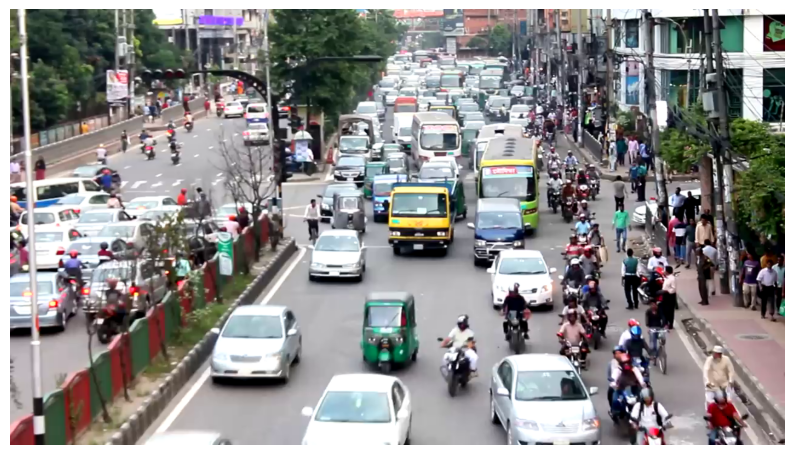

In [45]:
# membuat generator frame
generator = sv.get_video_frames_generator(VIDEO_PATH)

# menampilkan frame pertama
iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame, (10, 10))

Deteksi kendaraan dalam frame

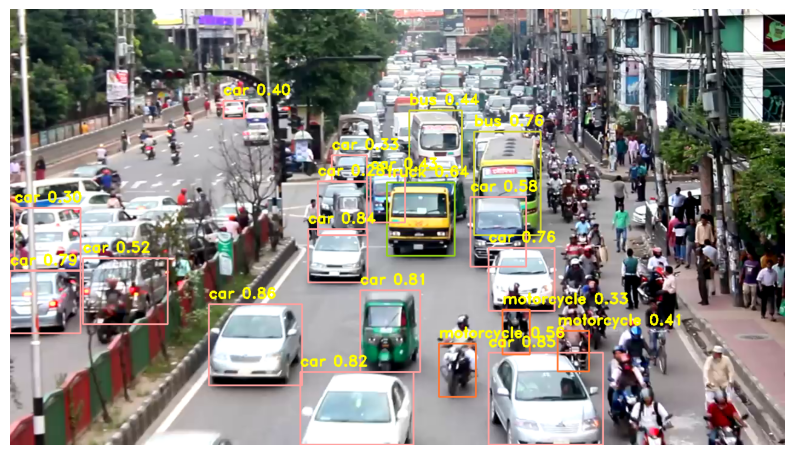

In [46]:
# melakukan deteksi objek pada frame menggunakan model YOLO
results = model(frame, verbose=False)[0]

# mengkonversi hasil deteksi ke dalam format yang dapat digunakan oleh Supervision
detections = sv.Detections.from_ultralytics(results)
# memfilter hasil deteksi untuk hanya menyertakan kelas yang ingin dideteksi
detections = detections[np.isin(detections.class_id, classes)]

# membuat bounding box pada frame
box_annotator = sv.BoxAnnotator(thickness=2)
annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)

# membuat label untuk setiap deteksi
labels = []
for confidence, class_id in zip(detections.confidence, detections.class_id):
    label = f"{CLASS_NAME_DICT[class_id]} {confidence:.2f}"
    labels.append(label)

# menambahkan label di atas bounding box
for box, label in zip(detections.xyxy, labels):
    x1, y1, x2, y2 = box.astype(int)
    cv2.putText(
        annotated_frame,
        label,
        (x1, y1 - 10),
        fontFace=cv2.FONT_HERSHEY_DUPLEX,
        fontScale=0.8,
        color=(0, 255, 255),
        thickness=2
    )

# menampilkan frame dengan bounding box dan label
sv.plot_image(annotated_frame, (10, 10))

## Track and Count Vehicles

mendapatkan informasi video seperti frame rate dan resolusinya

In [47]:
sv.VideoInfo.from_video_path(VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=25, total_frames=7740)

In [48]:
# membuat instance dari ByteTrack untuk pelacakan objek
byte_tracker = sv.ByteTrack(frame_rate=25)

# membuat box annotator untuk menggambar bounding box pada frame
box_annotator = sv.BoxAnnotator(thickness=2)

# membuat jejak pelacakan untuk menggambar jejak objek yang terdeteksi
trace_annotator = sv.TraceAnnotator(thickness=2, trace_length=60)

## Menghitung kecepatan kendaraan

In [49]:
def calculate_speed(detections, previous_positions, frame_rate=25, pixels_per_meter=10):
    speeds = []
    # Menghitung kecepatan objek berdasarkan posisi sebelumnya dan saat ini
    for detection, tracker_id in zip(detections.xyxy, detections.tracker_id):
        x1, y1, x2, y2 = detection.astype(int)
        if tracker_id in previous_positions:
            prev_x, prev_y = previous_positions[tracker_id]
            distance_pixels = np.sqrt((x1 - prev_x)**2 + (y1 - prev_y)**2)
            distance_meters = distance_pixels / pixels_per_meter
            speed_m_per_s = distance_meters * frame_rate
            # Konversi kecepatan dari px/s ke km/h
            speed_km_per_h = speed_m_per_s * 3.6
            speeds.append(speed_km_per_h)
        previous_positions[tracker_id] = (x1, y1)
    # Menghitung kecepatan rata-rata
    avg_speed = np.mean(speeds) if speeds else 0
    return avg_speed

## Fungsi Memeriksa Kemacetan

In [50]:
def check_congestion(detections, frame, previous_positions, count_threshold=20, speed_threshold=20):
    # Menghitung jumlah kendaraan
    vehicle_count = len(detections)
    cv2.putText(frame, f"Jumlah Kendaraan: {vehicle_count}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Menghitung kecepatan rata-rata kendaraan
    avg_speed = calculate_speed(detections, previous_positions)

    # Menampilkan kecepatan rata-rata
    cv2.putText(frame, f"Kecepatan Rata-Rata: {avg_speed:.2f} KmH", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Deteksi kemacetan berdasarkan jumlah kendaraan
    if vehicle_count > count_threshold:
        cv2.putText(frame, "Kemacetan Terjadi! (Jumlah Kendaraan)", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        print("Kemacetan Terdeteksi! (Jumlah Kendaraan)")

    # Deteksi kemacetan berdasarkan kecepatan rata-rata
    if avg_speed < speed_threshold:
        cv2.putText(frame, "Kemacetan Terjadi! (Kecepatan Rendah)", (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        print("Kemacetan Terdeteksi! (Kecepatan Rendah)")


## Memproses Frame Video

In [51]:
# Mendefinisikan variabel untuk menyimpan posisi kendaraan sebelumnya
previous_positions = {}

def process_frame(frame):
    # Mendapatkan hasil deteksi dari model YOLO
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    
    # Hanya mengambil kendaraan dengan kelas yang diinginkan
    detections = detections[np.isin(detections.class_id, classes)]
    
    # Melakukan pelacakan kendaraan
    detections = byte_tracker.update_with_detections(detections)

    # Menambahkan label pada frame
    labels = []
    for confidence, class_id in zip(detections.confidence, detections.class_id):
        label = f"{CLASS_NAME_DICT[class_id]} {confidence:.2f}"
        labels.append(label)

    annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    # Menambahkan teks di atas kotak pembatas (bounding box)
    for box, label in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = box.astype(int)
        cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_DUPLEX, 0.8, (0, 255, 255), 2)

    # Memeriksa kemacetan berdasarkan jumlah kendaraan dan kecepatan
    check_congestion(detections, annotated_frame, previous_positions)

    return annotated_frame


## Program Untuk Menjalankan

In [52]:
# Jika ingin menggunakan webcam
# video_cap = cv2.VideoCapture(0)

# Jika ingin menggunakan video dari file
video_cap = cv2.VideoCapture(VIDEO_PATH)

while True:
  # membaca frame dari video
  success, frame = video_cap.read()
  if not success:
    break
  # mengubah ukuran frame
  frame = cv2.resize(frame, (1280, 720))
  # mengubah warna frame dari BGR ke RGB
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  # memproses frame untuk deteksi dan pelacakan
  processed_frame = process_frame(frame)
  # menampilkan frame yang telah diproses
  cv2.imshow('frame', processed_frame)
  # menghentikan program jika tombol 'q' ditekan
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

# membersihkan semua jendela tampilan dari OpenCV
video_cap.release()
cv2.destroyAllWindows()

Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdeteksi! (Kecepatan Rendah)
Kemacetan Terdeteksi! (Jumlah Kendaraan)
Kemacetan Terdet